## Setting up visualization portion of project

In [1]:
# visualization tools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool

In [2]:
# data tools
import datetime as dt
import numpy as np
from random import sample
from scipy import stats

In [3]:
# access to .csv job files
from os import listdir

In [7]:
# collect file names for all jobs
train_files = [ '../jobs/train/'+file for file in listdir('../jobs/train/') if file.startswith('comet') ]
test_files = [ '../jobs/test/'+file for file in listdir('../jobs/test/') if file.startswith('comet')]

all_jobs = [ *train_files, *test_files]

In [8]:
len(all_jobs)

10617

### Parse for trends
**Notes:**
    * Certain categories have been pre-selected to further analysis:
        * intel_hsw: Intel Haswell Processor (HSW) (per core)
        * intel_rapl: Running average power limit
        * ib: Infiniband usage
        * ib_sw: InfiniBand usage
        * ib_ext: Infiniband usage
        * llite: Lustre filesystem usage (per mount),
        * lnet: Lustre network usage
        * mdc: Lustre network usage
        * osc: Lustre filesystem usage
        * block: block device statistics (per device)
        * cpu: scheduler accounting (per CPU)
        * mem: memory usage (per socket)
        * net: network device usage (per device)
        * nfs: NFS system usage
        * proc: Process specific data (MaxRSS, executable name etc.)
        * sysv_shm SysV shared memory segment usage
        * tmpfs: ram-backed filesystem usage (per mount)
        * vm: virtual memory statistics
    * Extreme case will also be evaluated

In [176]:
# extreme values
most_cycles = ( '{host}_{jobid}', pd.DataFrame() )
most_stats = ( '{host}_{jobid}', pd.DataFrame() )

# specific values
intel_hsw_dfs = []
intel_rapl_dfs = []
ib_dfs = []
ib_sw_dfs = []
ib_ext_dfs = []
llite_dfs = []
#lnet_dfs = []
mdc_dfs = []
osc_dfs = []
block_dfs = []
cpu_dfs = []
mem_dfs = []
net_dfs = []
nfs_dfs = []
#proc_dfs = []
#ps_dfs = []
#sysv_shm_dfs = []
tmpfs_dfs = []
vm_dfs = []

In [177]:
cols = [
    ( intel_hsw_dfs,"Intel Haswell Processor (HSW) (per core)" ),
    ( intel_rapl_dfs,"Running average power limit" ),
    ( ib_dfs, "Infiniband usage (default)" ),
    ( ib_sw_dfs, "InfiniBand usage (sw)" ),
    ( ib_ext_dfs, "Infiniband usage (ext)" ),
    ( llite_dfs, "Lustre filesystem usage (per mount)" ),
    #( lnet_dfs, "Lustre network usage (lnet)" ),
    ( mdc_dfs, "Lustre network usage (mdc)" ),
    ( osc_dfs, "Lustre filesystem usage (osc)" ),
    ( block_dfs, "Block device statistics (per device)" ),
    ( cpu_dfs, "Scheduler accounting (per CPU)" ),
    ( mem_dfs, "Memory usage (per socket)" ),
    ( net_dfs, "Network device usage (per device)" ),
    ( nfs_dfs, "NFS system usage" ),
    #( proc_dfs, "Process specific data (MaxRSS, executable name etc.)" ),
    #( ps_dfs, "Process statistics" ),
    #( sysv_shm_dfs, "SysV shared memory segment usage" ),
    ( tmpfs_dfs, "Ram-backed filesystem usage (per mount)" ),
    ( vm_dfs, "Virtual memory statistics" )
] 

In [178]:
for i in range( len(all_jobs) ):
    file = all_jobs[i]
    df = pd.read_csv( file)
    
    # find job with most cycles of collected stats
    if (df.shape[0] > most_cycles[1].shape[0]): most_cycles = (file,df)
    # find job with most types of stats
    if (df.shape[1] > most_stats[1].shape[1]): most_stats = (file,df)
        
    # collect jobs with specific values    
    if "Intel Haswell Processor (HSW) (per core)" in df: intel_hsw_dfs.append((file,df)) 
    if "Running average power limit" in df: intel_rapl_dfs.append((file,df))
    if "Infiniband usage (default)" in df: ib_dfs.append((file,df))
    if "InfiniBand usage (sw)" in df: ib_sw_dfs.append((file,df))
    if "Infiniband usage (ext)" in df: ib_ext_dfs.append((file,df))
    if "Lustre filesystem usage (per mount)" in df: llite_dfs.append((file,df))
    #if "Lustre network usage (lnet)" in df: lnet_dfs.append((file,df))
    if "Lustre network usage (mdc)" in df: mdc_dfs.append((file,df))
    if "Lustre filesystem usage (osc)" in df: osc_dfs.append((file,df))
    if "Block device statistics (per device)" in df: block_dfs.append((file,df))
    if "Scheduler accounting (per CPU)" in df: cpu_dfs.append((file,df))
    if "Memory usage (per socket)" in df: mem_dfs.append((file,df))
    if "Network device usage (per device)" in df: net_dfs.append((file,df))
    if "NFS system usage" in df: nfs_dfs.append((file,df))
    #if "Process specific data (MaxRSS, executable name etc.)" in df: proc_dfs.append((file,df))
    #if "Process statistics" in df: ps_dfs.append((file,df))
    #if "SysV shared memory segment usage" in df: sysv_shm_dfs.append((file,df))
    if "Ram-backed filesystem usage (per mount)" in df: tmpfs_dfs.append((file,df))
    if "Virtual memory statistics" in df: vm_dfs.append((file,df))

In [184]:
most_cycles[1]

,Cycle,Block device statistics (per device),Scheduler accounting (per CPU),Infiniband usage (default),Infiniband usage (ext),InfiniBand usage (sw),Intel Haswell Processor (HSW) (per core),Caching Agent (CBo) for SNB (HSW) (per socket),Home Agent Unit for SNB (HSW) (per socket),Integrated Memory Controller for SNB (HSW) (per socket),...,Memory usage (per socket),Network device usage (per device),NFS system usage,NUMA statistics (per socket),"Process specific data (MaxRSS, executable name etc.)",Process statistics,SysV shared memory segment usage,Ram-backed filesystem usage (per mount),Dentry/file/inode cache usage,Virtual memory statistics
0,00:05:10,2.233600e+07,663965.571,0.0,39748465.7,9.894929e+07,1.408133e+12,3.916951e+10,3.502309e+13,7.442814e+08,...,8.628043e+09,1.620759e+06,0.00,780286.000,1168080.933,1.462143e+08,0.0,65961986.5,13724.000,2.301076e+07
1,00:06:59,5.396789e+07,1891177.143,0.0,112431613.0,2.798981e+08,2.834801e+14,2.815308e+14,3.313158e+14,2.251811e+14,...,8.630453e+09,4.540888e+06,67.33,2047090.667,1168080.933,4.163055e+08,0.0,65961986.5,21224.000,5.595069e+07
2,00:07:09,1.222653e+08,4342705.143,0.0,259886977.0,6.469736e+08,8.464272e+14,8.444806e+14,8.942723e+14,6.755411e+14,...,8.633021e+09,1.060311e+07,67.33,4586023.000,1168080.933,9.560565e+08,0.0,65961986.5,21342.667,1.059396e+08
3,00:15:10,2.377984e+07,672477.571,0.0,40271436.9,1.002511e+08,1.426114e+12,3.967467e+10,3.547210e+13,7.612391e+08,...,8.628104e+09,1.644257e+06,0.00,791419.000,1168080.933,1.481060e+08,0.0,65961986.5,13660.000,2.421918e+07
4,00:16:59,5.406325e+07,1899689.714,0.0,112943936.4,2.811735e+08,2.834981e+14,2.815313e+14,3.317648e+14,2.251811e+14,...,8.630465e+09,4.562483e+06,67.33,2056122.667,1168080.933,4.181786e+08,0.0,65961986.5,21240.000,5.606208e+07
5,00:17:09,1.237007e+08,4351217.000,0.0,260441777.4,6.483543e+08,8.464451e+14,8.444811e+14,8.947213e+14,6.755411e+14,...,8.633288e+09,1.062237e+07,67.33,4605888.000,1168080.933,9.579606e+08,0.0,65961986.5,21327.000,1.071565e+08
6,00:17:10,9.056390e+07,3125519.571,0.0,185392298.0,4.615426e+08,5.649706e+14,5.630062e+14,6.132474e+14,4.503610e+14,...,8.632166e+09,7.531734e+06,67.33,3289748.667,1168080.933,6.879314e+08,0.0,65961986.5,21257.333,7.350740e+07
7,00:25:10,2.544492e+07,680988.714,0.0,40788395.3,1.015380e+08,1.444158e+12,4.017756e+10,3.592111e+13,7.778941e+08,...,8.628131e+09,1.668386e+06,0.00,813881.667,1168080.933,1.499808e+08,0.0,65961986.5,13741.667,2.557059e+07
8,00:26:59,5.419846e+07,1908201.429,0.0,113447990.4,2.824284e+08,2.835162e+14,2.815318e+14,3.322138e+14,2.251811e+14,...,8.630476e+09,4.582573e+06,67.33,2068784.667,1168080.933,4.200526e+08,0.0,65961986.5,21256.333,5.623072e+07
9,00:27:09,1.252719e+08,4359730.571,0.0,260951106.0,6.496223e+08,8.464632e+14,8.444816e+14,8.951704e+14,6.755411e+14,...,8.633286e+09,1.064121e+07,67.33,4626848.667,1168080.933,9.598348e+08,0.0,65961986.5,21359.333,1.084318e+08


In [180]:
most_stats[1]

,Cycle,Block device statistics (per device),Scheduler accounting (per CPU),Infiniband usage (default),Infiniband usage (ext),InfiniBand usage (sw),Intel Haswell Processor (HSW) (per core),Caching Agent (CBo) for SNB (HSW) (per socket),Home Agent Unit for SNB (HSW) (per socket),Integrated Memory Controller for SNB (HSW) (per socket),...,Network device usage (per device),NFS system usage,NUMA statistics (per socket),Lustre filesystem usage (osc),"Process specific data (MaxRSS, executable name etc.)",Process statistics,SysV shared memory segment usage,Ram-backed filesystem usage (per mount),Dentry/file/inode cache usage,Virtual memory statistics
0,00:41:33,0.000000e+00,0.000,0.0,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000,0.0,0.000000e+00,0.0,34239.4,6.162860e+02,0.0,0.5,20175.000,0.000000e+00
1,00:51:33,9.019902e+06,8564.714,0.0,5.464135e+10,1.364903e+11,1.165101e+09,7.603681e+10,4.754782e+11,1.392123e+11,...,57998.217,0.0,2.744191e+06,793.4,34239.4,4.637056e+06,0.0,7.0,22340.000,1.264204e+07
2,01:01:33,9.912241e+06,17131.000,0.0,1.136762e+11,2.839549e+11,2.108158e+09,1.498462e+11,9.506452e+11,2.780652e+11,...,103579.261,0.0,5.614329e+06,1505.6,50893.8,7.793329e+06,0.0,7.0,22337.333,1.759385e+07
3,01:11:33,1.125866e+07,25697.000,0.0,1.721833e+11,4.301020e+11,3.136965e+09,2.216591e+11,1.425112e+12,4.165651e+11,...,142463.478,0.0,8.543252e+06,2142.0,51837.8,1.095381e+07,0.0,7.0,22335.667,2.309537e+07
4,01:21:33,1.141736e+07,34263.571,0.0,2.305498e+11,5.758980e+11,3.970212e+09,2.935114e+11,1.899554e+12,5.550521e+11,...,184940.217,0.0,1.148022e+07,3306.3,51994.6,1.410352e+07,0.0,7.0,22353.667,2.756497e+07


In [10]:
pd.read_csv( all_jobs[0] )

,Cycle,Block device statistics (per device),Scheduler accounting (per CPU),Infiniband usage (default),Infiniband usage (ext),InfiniBand usage (sw),Intel Haswell Processor (HSW) (per core),Caching Agent (CBo) for SNB (HSW) (per socket),Home Agent Unit for SNB (HSW) (per socket),Integrated Memory Controller for SNB (HSW) (per socket),...,Memory usage (per socket),Network device usage (per device),NFS system usage,NUMA statistics (per socket),"Process specific data (MaxRSS, executable name etc.)",Process statistics,SysV shared memory segment usage,Ram-backed filesystem usage (per mount),Dentry/file/inode cache usage,Virtual memory statistics
0,05:59:59,0.000,0.000,0.000,0.1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,8.574070e+09,0.000,0.0,0.000,231096.867,141.286,0.0,0.5,7446.667,0.000
1,06:09:59,1115006.636,8570.000,461.765,443951.3,1.105668e+06,4.959721e+07,5.923230e+06,1.816521e+11,13253004.4,...,8.574947e+09,4644.696,0.0,14254.333,231096.867,27892.429,0.0,0.5,7859.667,1203765.667
2,06:19:59,1417809.364,17139.714,920.706,877918.5,2.186563e+06,1.002623e+08,1.235332e+07,3.637875e+11,26476441.2,...,8.575076e+09,9477.826,0.0,29036.333,231096.867,56492.143,0.0,0.5,7908.000,1562784.810
3,06:29:59,2017781.000,25709.286,1394.176,1322207.5,3.293010e+06,1.606465e+08,1.904076e+07,5.455998e+11,39772440.4,...,8.576113e+09,14803.435,0.0,51610.000,231096.867,85169.429,0.0,0.5,7958.333,2291466.810
4,06:39:59,2101977.727,34276.714,1867.471,1757810.5,4.377899e+06,3.890725e+08,2.520958e+07,7.272520e+11,52994325.4,...,8.576126e+09,19182.913,0.0,65591.000,231096.867,112765.000,0.0,0.5,7974.000,2399557.667
5,06:49:59,3300778.909,42846.143,22349.824,117035479.8,2.923950e+08,3.524842e+09,1.597764e+08,9.155648e+11,72911722.0,...,8.982168e+09,24344.391,0.0,363554.333,231096.867,186725.000,0.0,65961986.5,9551.667,3832135.286
6,06:59:59,3418507.818,51417.286,22802.353,117464934.4,2.934647e+08,2.606744e+11,4.347285e+09,1.364583e+12,74422335.2,...,8.982559e+09,30075.217,0.0,371884.000,231096.867,214513.000,0.0,65961986.5,9795.000,3966438.571


In [11]:
pd.read_csv( all_jobs[1] )

,Cycle,Block device statistics (per device),Scheduler accounting (per CPU),Infiniband usage (default),Infiniband usage (ext),InfiniBand usage (sw),Intel Haswell Processor (HSW) (per core),Caching Agent (CBo) for SNB (HSW) (per socket),Home Agent Unit for SNB (HSW) (per socket),Integrated Memory Controller for SNB (HSW) (per socket),...,Memory usage (per socket),Network device usage (per device),NFS system usage,NUMA statistics (per socket),"Process specific data (MaxRSS, executable name etc.)",Process statistics,SysV shared memory segment usage,Ram-backed filesystem usage (per mount),Dentry/file/inode cache usage,Virtual memory statistics
0,01:47:25,0.000000e+00,0.000,0.0,0.1,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,8.582558e+09,0.000,0.000,0.000,1153247.2,925.714,0.0,0.5,7358.333,0.000000e+00
1,01:57:25,2.680465e+09,8570.571,0.0,11000736.5,27488997.00,3.107251e+11,1.274611e+10,4.506033e+11,442089237.8,...,9.192268e+09,40652.609,0.117,3952671.667,1153247.2,557434.429,0.0,0.5,8028.333,2.806622e+09
2,02:07:25,4.613967e+09,17145.286,0.0,11440125.9,28583131.25,6.211998e+11,1.277849e+10,8.998944e+11,504843597.6,...,9.640821e+09,80371.348,0.117,4613925.667,1153247.2,1029188.857,0.0,0.5,8060.000,4.835777e+09
3,02:17:25,5.960940e+09,25715.857,0.0,11887997.7,29698211.75,9.365150e+11,1.279743e+10,1.349123e+12,548511648.8,...,9.955193e+09,138510.783,0.117,5103718.833,1153247.2,1470696.000,0.0,0.5,8039.667,6.248025e+09
4,02:27:25,7.221722e+09,34279.429,0.0,12335905.7,30813416.25,1.229019e+12,1.289100e+10,1.798280e+12,605199195.6,...,9.951200e+09,188119.478,0.117,5180371.167,1153247.2,1878750.571,0.0,0.5,8051.000,7.568282e+09
5,02:37:25,8.421621e+09,42850.286,0.0,12782735.1,31925888.50,1.552162e+12,1.295195e+10,2.247426e+12,665631119.0,...,1.001422e+10,226864.348,0.117,5360011.500,1153247.2,2267804.000,0.0,0.5,8051.333,8.825255e+09
6,02:47:25,9.658884e+09,51420.571,0.0,13229176.9,33037418.75,1.858722e+12,1.299607e+10,2.696613e+12,710822770.0,...,1.027784e+10,276445.304,0.117,5640362.833,1153247.2,2691984.000,0.0,0.5,8030.667,1.012174e+10
7,02:57:25,1.043167e+10,59989.857,0.0,13672747.7,34141900.50,2.090465e+12,1.355941e+10,3.136429e+12,904933954.4,...,1.042596e+10,321232.043,0.117,5800015.167,1153247.2,3021218.000,0.0,0.5,8169.000,1.093191e+10


# Begin Visualizations

*Table below references the index position of a statistic in the master list above,* "cols"

In [63]:
%%HTML
<table style="border-collapse:collapse;border-spacing:0;border:none;border-color:#aaa;margin:0px auto" class="tg"><tr><th style="font-family:Arial, sans-serif;font-size:16px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#aaa;color:#fff;background-color:#f38630;text-align:center;vertical-align:top">For<br>Training</th><th style="font-family:Arial, sans-serif;font-size:16px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#aaa;color:#fff;background-color:#f38630;text-align:center;vertical-align:top">Two<br> Trends</th><th style="font-family:Arial, sans-serif;font-size:16px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#aaa;color:#fff;background-color:#f38630;text-align:center;vertical-align:top">Unique</th></tr><tr><td style="font-family:Arial, sans-serif;font-size:16px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#aaa;color:#333;background-color:#fff;text-align:center;vertical-align:top">7, 8, 18</td><td style="font-family:Arial, sans-serif;font-size:16px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#aaa;color:#333;background-color:#efefef;text-align:center;vertical-align:top">0, 2, 3, 4, 9, 12</td><td style="font-family:Arial, sans-serif;font-size:16px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#aaa;color:#333;background-color:#fff;text-align:center;vertical-align:top">1, 11</td></tr></table>

ForTraining,Two Trends,Unique
"7, 8, 18","0, 4, 9, 12","1, 11"


In [11]:
def ordinalize( x ):
    x = abs(int(x))
    
    if (x % 10 < 4) or (x % 100 < 4):
        return {
            1: f"{x}st",
            2: f"{x}nd",
            3: f"{x}rd",
        }.get(x % 10, "th")
    else:
        return f"{x}th"

In [12]:
def retMode ( df ):
    return int( stats.mode( [tup[1].shape[0] for tup in df if tup[1].shape[0] > 5] )[0][0] )

### matplotlib with seaborn

In [144]:
def samplePlot ( df, col ):
    mode = retMode(df)
    modeList = [ tup[1] for tup in df if tup[1].shape[0] == mode ]
    s = sample( modeList , len(modeList) )
    
    for job in s:
        plt.plot( job[col] )
    
    plt.grid( True )
    plt.gcf().set_size_inches(15, 11)
    sns.despine()
    
def samplePlot_n ( df, col, n ):
    mode = retMode(df)
    s = sample( [ tup[1] for tup in df if tup[1].shape[0] == mode ] , n )
    
    for job in s:
        plt.plot( job[col] )
    
    plt.grid( True )
    plt.gcf().set_size_inches(15, 11)
    sns.despine()

In [198]:
type(intel_rapl_dfs[0][1]["Running average power limit"])

pandas.core.series.Series

In [193]:
sns.set("notebook", palette='inferno', font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.scatter()

TypeError: scatter() missing 1 required positional argument: 'y'

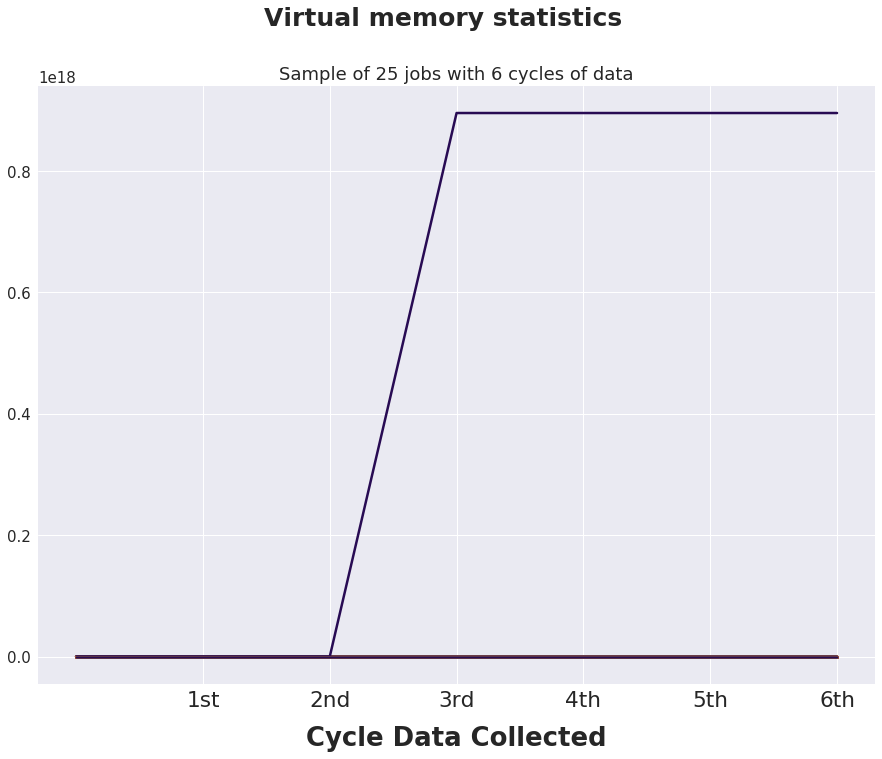

In [145]:
themes = ['inferno', 'ocean', 'tab20c', 'winter', 'summer', 'Wistia', 'hot', 'bone', 'pink',
         'BuGn', 'Blues', 'Purples', 'GnBu', 'YlGn', 'plasma', 'magma', 'viridis', 'BuPu', 'Blues']
n = 25

for i in range( len(cols) ):
    trend = cols[i]
    
    # choose ranges
    xrng = np.arange( 1,retMode(trend[0]) )
    
    # generate plot
    sns.set("notebook", palette=themes[i], font_scale=1.5, rc={"lines.linewidth": 2.5})
    samplePlot_n( trend[0], trend[1], n)
    
    # label and format plot
    plt.suptitle(    trend[1], fontsize=25, fontweight='bold' )
    plt.title(       f"Sample of {n} jobs with {len(xrng)} cycles of data")
    plt.xticks(      xrng, [ ordinalize(i) for i in xrng ], fontsize='large' )
    plt.xlabel(      "Cycle Data Collected", labelpad=15, fontweight='bold', fontsize='x-large' )
    #plt.ylabel(      f"SUs", labelpad=15, fontweight='bold', fontsize='x-large' )
    
    # save
    plt.savefig( f"./graphs/{trend[1]}_sample.png", bbox='tight')

In [26]:
sns.set()

# Load the iris dataset
iris = sns.load_dataset(trend[0])

# Plot sepal with as a function of sepal_length across days
g = sns.lmplot(x="sepal_length", y="sepal_width", hue="species",
               truncate=True, size=5, data=iris)

# Use more informative axis labels than are provided by default
g.set_axis_labels("Sepal length (mm)", "Sepal width (mm)")

URLError: <urlopen error [Errno 32] Broken pipe>

In [ ]:
sns.set(style="whitegrid")

# Load the example iris dataset
diamonds = sns.load_dataset("diamonds")

# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
sns.scatterplot(x="carat", y="price",
                hue="clarity", size="depth",
                palette="ch:r=-.2,d=.3_r",
                hue_order=clarity_ranking,
                sizes=(1, 8), linewidth=0,
                data=diamonds, ax=ax)

# Bokeh Visualizations

In [ ]:
output_file('bokeh_example.html')

sample = most_cycles[1] #.sample(50)
source = ColumnDataSource(sample)
p = figure()
#p.circle(x='TOTAL_TONS', y='AC_ATTACKING',
#         source=source,
#         size=10, color='green')
#p.title.text = 'Attacking Aircraft and Munitions Dropped'
#p.xaxis.axis_label = 'Tons of Munitions Dropped'
#p.yaxis.axis_label = 'Number of Attacking Aircraft'
#hover = HoverTool()
#hover.tooltips=[
#    ('Attack Date', '@MSNDATE'),
#    ('Attacking Aircraft', '@AC_ATTACKING'),
#    ('Tons of Munitions', '@TOTAL_TONS'),
#    ('Type of Aircraft', '@AIRCRAFT_NAME')
#]
#
#p.add_tools(hover)
#
#show(p)